In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# The are the labels for each of the 24 videos shown to participants in the 3 trials.

labels_exp_1=['1','2','3','0','2','0','0','1','0','1','2','1','1','1','2','3','2','2','3','3','0','3','0','3']
labels_exp_2=['2','1','3','0','0','2','0','2','3','3','2','3','2','0','1','1','2','1','0','3','0','1','3','1']
labels_exp_3=['1','2','2','1','3','3','3','1','1','2','1','0','2','3','3','0','2','3','0','0','2','0','1','0']

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


# Preprocessing the input files to pull DE data for 41 channels and all 5 fequency bands

In [ ]:
# Here we are extracting 3 frequency channels for 6 electrodes for DE data
file_label=[]
dir_paths =['/content/drive/My Drive/SEED-IV/eeg_feature_smooth/1/','/content/drive/My Drive/SEED-IV/eeg_feature_smooth/2/','/content/drive/My Drive/SEED-IV/eeg_feature_smooth/3/']
d=1
for directory in dir_paths:
    files = [f for f in listdir(directory) if isfile(join(directory, f))]
    f=1
    for file in files:
        df = loadmat(directory+file)
        columns=list(df.keys())
        i=3
        subset=[]
        while i<99:
            subset.append(columns[i])
            i=i+4
        j=1
        for col in subset:
            #print(df[col].shape)
            channel=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40] # Corresponds to channels FT7,T7,TP7,FT8,T8,P8
            freq_bands=[0,1,2,3,4]
            fr=1
            for freq in freq_bands:
                for chn in channel:
                    # out of the 5 freq bands alpha, beta and gamma contain the most discriminative information
                    a1= df[col][chn,:,freq]
                    padded_array1 = np.zeros((64, ))
                    shape1 = np.shape(a1)
                    padded_array1[:shape1[0],] = a1
                                       
                 
                    if chn==0:
                        f_channel = padded_array1
                        
                    else:
                        f_channel =np.vstack((f_channel,padded_array1))
                        #print(f_channel)
                        
                if fr==1:
                    freq_f_channel=f_channel
                    #print(freq_f_channel.shape)
                else:
                    freq_f_channel=np.vstack((freq_f_channel,f_channel))
                fr=fr+1
            freq_f_channel.reshape(41,64,5)
            #print(freq_f_channel)
            if j==1:
                trial_data=freq_f_channel
            else:
                trial_data=np.vstack((trial_data,freq_f_channel))
                #print(trial_data.shape)
            j=j+1
            if directory=='/content/drive/My Drive/SEED-IV/eeg_feature_smooth/1/' and j==25:
                file_label.append(labels_exp_1)
                #print(file_label)
            elif directory=='/content/drive/My Drive/SEED-IV/eeg_feature_smooth/2/' and j==25:
                file_label.append(labels_exp_2)
            elif directory=='/content/drive/My Drive/SEED-IV/eeg_feature_smooth/3/' and j==25:
                file_label.append(labels_exp_3)
        if f==1:
            file_data=trial_data
        else:
            file_data=np.vstack((file_data,trial_data))
            #print(file_data.shape)
        f=f+1
    if d==1:
        dir_data=file_data
    else:
        dir_data=np.vstack((dir_data,file_data))
        #print(dir_data.shape)
    d=d+1

flat_list = [item for sublist in file_label for item in sublist]

In [ ]:
dir_data.shape

(221400, 64)

In [ ]:
model_data=dir_data.reshape(1080,5,41,64)

In [ ]:
len(flat_list)

1080

In [ ]:
np.array(flat_list).shape

(1080,)

In [ ]:
for i in range(0, len(flat_list)): 
    flat_list[i] = int(flat_list[i]) 

In [ ]:
# https://github.com/Song-zhenzhen/EEG_emotion_classification_use_CNN-and-RNN/blob/master/CNN%2BRNN.py
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv1D, GRU, GlobalAveragePooling1D, Activation, Flatten, Dropout, Dense, MaxPool1D
from keras.models import Sequential
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

df_all = min_max_scaler.fit_transform(dir_data)

df_all = df_all.reshape(1080,5,41,64)

index=np.ones(1080)
for i in range(1080):
    index[i]=i
np.random.shuffle(index)
index=index.astype('int64')
index_train=index[0:810]
index_test=index[810:]
x_total = df_all[index_train]
y_total = np.array(flat_list)[index_train]
x_test = df_all[index_test]
y_test = np.array(flat_list)[index_test]
x_train, x_valid, y_train, y_valid = train_test_split(x_total, y_total, test_size = 0.2, random_state = 1)


In [ ]:
x_train.shape

(648, 5, 41, 64)

In [ ]:
y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)
y_valid = to_categorical(y_valid, num_classes = 4)

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend, models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Model 4: Single Modality, using DE data from 41-channels (0-40) and 5-frequency bands (δ , θ ,α, β and γ)

In [ ]:
backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (2,2), activation = 'relu', input_shape = (5,41, 64)))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, 
          y_train, 
          epochs = 20, 
          batch_size = 32,  
          validation_data=(x_valid, y_valid),
          verbose = 1,
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

Epoch 1/20
21/21 [==============================] - 0s 22ms/step - loss: 1.4554 - accuracy: 0.4306 - val_loss: 1.2887 - val_accuracy: 0.3642
Epoch 2/20
21/21 [==============================] - 0s 14ms/step - loss: 1.1439 - accuracy: 0.5648 - val_loss: 1.2282 - val_accuracy: 0.5926
Epoch 3/20
21/21 [==============================] - 0s 13ms/step - loss: 0.9875 - accuracy: 0.5972 - val_loss: 1.1306 - val_accuracy: 0.6975
Epoch 4/20
21/21 [==============================] - 0s 14ms/step - loss: 0.8198 - accuracy: 0.6574 - val_loss: 1.1044 - val_accuracy: 0.6543
Epoch 5/20
21/21 [==============================] - 0s 14ms/step - loss: 0.8076 - accuracy: 0.6636 - val_loss: 1.1351 - val_accuracy: 0.5864
Epoch 6/20
21/21 [==============================] - 0s 13ms/step - loss: 0.7360 - accuracy: 0.6744 - val_loss: 1.0619 - val_accuracy: 0.6420
Epoch 7/20
21/21 [==============================] - 0s 13ms/step - loss: 0.7541 - accuracy: 0.6836 - val_loss: 1.0100 - val_accuracy: 0.6358
Epoch 8/20
21

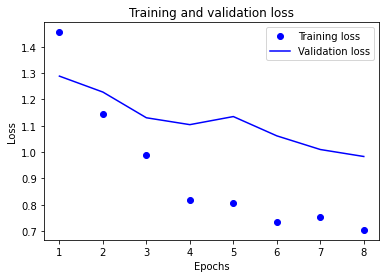

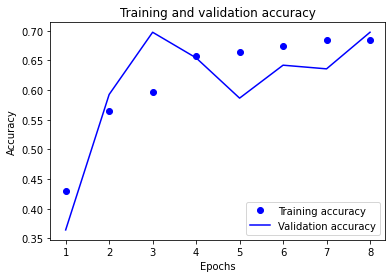

9/9 [==============================] - 0s 3ms/step - loss: 1.1741 - accuracy: 0.6037
test_acc: 0.6037036776542664


In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

In [ ]:
# load eye data in the model
file_label=[]
dir_paths =['/content/drive/My Drive/SEED-IV/eye_feature_smooth/1/','/content/drive/My Drive/SEED-IV/eye_feature_smooth/2/','/content/drive/My Drive/SEED-IV/eye_feature_smooth/3/']
d=1
for directory in dir_paths:
    files = [f for f in listdir(directory) if isfile(join(directory, f))]

    for file in files:
        df = loadmat(directory+file)

        eye_columns=list(df.keys())[3:]

        for col in eye_columns:

          a1= df[col]
          padded_array1 = np.zeros((31,64))
          shape1 = np.shape(a1)
          padded_array1[:shape1[0],:shape1[1]] = a1

          if d==1:
            file_eye_data = padded_array1
          else:
            #print(padded_array1.shape)
            file_eye_data =np.vstack((file_eye_data,padded_array1))
          d=d+1

In [ ]:
file_eye_data.shape

(33480, 64)

In [ ]:
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv1D, GRU, GlobalAveragePooling1D, Activation, Flatten, Dropout, Dense, MaxPool1D
from keras.models import Sequential
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split
min_max_scaler = preprocessing.MinMaxScaler()
#ValueError: Found array with dim 3. MinMaxScaler expected <= 2.
df_all = min_max_scaler.fit_transform(file_eye_data)
eye_data=df_all.reshape(1080,31,64)

In [ ]:
index=np.ones(1080)
for i in range(1080):
    index[i]=i
np.random.shuffle(index)
index=index.astype('int64')
index_train=index[0:810]
index_test=index[810:]
x_total = eye_data[index_train]
y_total = np.array(flat_list)[index_train]
x_test = eye_data[index_test]
y_test = np.array(flat_list)[index_test]
x_train, x_valid, y_train, y_valid = train_test_split(x_total, y_total, test_size = 0.2, random_state = 1)

y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)
y_valid = to_categorical(y_valid, num_classes = 4)

In [ ]:
# This is 2nd run for the model that uses only eye movement data

In [ ]:
backend.clear_session()

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation = 'relu', input_shape = (31, 64)))
model.add(layers.MaxPool1D((2)))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit(x_train, 
          y_train, 
          epochs = 20, 
          batch_size = 32,  
          validation_data=(x_valid, y_valid),
          verbose = 1,
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

Epoch 1/20
21/21 [==============================] - 0s 11ms/step - loss: 1.4432 - accuracy: 0.2886 - val_loss: nan - val_accuracy: 0.4259
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 1.2284 - accuracy: 0.4398 - val_loss: nan - val_accuracy: 0.4568
Epoch 3/20
21/21 [==============================] - 0s 5ms/step - loss: 1.1432 - accuracy: 0.4923 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 1.0696 - accuracy: 0.5185 - val_loss: nan - val_accuracy: 0.4259
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 1.0250 - accuracy: 0.5556 - val_loss: nan - val_accuracy: 0.4383
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.9587 - accuracy: 0.5679 - val_loss: nan - val_accuracy: 0.5062
Epoch 7/20
21/21 [==============================] - 0s 5ms/step - loss: 0.9350 - accuracy: 0.5910 - val_loss: nan - val_accuracy: 0.5247
Epoch 8/20
21/21 [======================

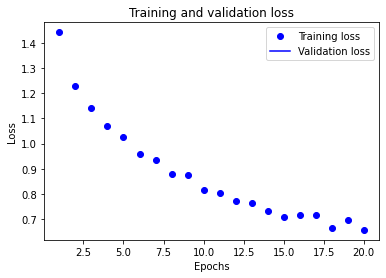

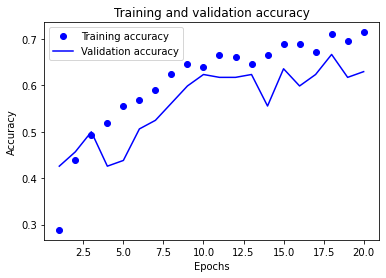

9/9 [==============================] - 0s 2ms/step - loss: 0.9683 - accuracy: 0.6963
test_acc: 0.6962962746620178


In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

In [ ]:
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv1D, GRU, GlobalAveragePooling1D, Activation, Flatten, Dropout, Dense, MaxPool1D
from keras.models import Sequential
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split

In [ ]:
# Using functional API for multi modal input 
# eeg data
# df_all.shape (33480, 64)
# eye data
# file_eye_data.shape (33480, 64)

min_max_scaler = preprocessing.MinMaxScaler()
eeg_data_all = min_max_scaler.fit_transform(dir_data)
eye_data_all = min_max_scaler.fit_transform(file_eye_data)

eeg_data_reshaped =eeg_data_all.reshape(1080,41,5,64) # switched 41 & 5

eye_data_reshaped =eye_data_all.reshape(1080,31,64)

index=np.ones(1080)
for i in range(1080):
    index[i]=i
np.random.shuffle(index)
index=index.astype('int64')
index_train=index[0:810]
index_test=index[810:]

eeg_x_total = eeg_data_reshaped[index_train]
y_total = np.array(flat_list)[index_train]
eeg_x_test = eeg_data_reshaped[index_test]
y_test = np.array(flat_list)[index_test]
eeg_x_train, eeg_x_valid, y_train, y_valid = train_test_split(eeg_x_total, y_total, test_size = 0.2, random_state = 1)

eye_x_total = eye_data_reshaped[index_train]

eye_x_test = eye_data_reshaped[index_test]

eye_x_train, eye_x_valid = train_test_split(eye_x_total, test_size = 0.2, random_state = 1)

y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)
y_valid = to_categorical(y_valid, num_classes = 4)




In [ ]:
eye_x_train .shape

(648, 31, 64)

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: protobuf, termcolor, six, h5py, absl-py, numpy, opt-einsum, google-pasta, scipy, wheel, grpcio, tensorboard, wrapt, gast, astunparse, keras-preprocessing, tensorflow-estimator
Required-by: fancyimpute


In [ ]:
#import tensorflow as tf
from keras.models import Model
from keras import layers
from keras import Input
from keras.utils import plot_model

In [ ]:
#from tensorflow.keras import layers
from keras.layers import Conv1D, Conv2D, GRU, GlobalAveragePooling1D, Activation, Flatten, Dropout, Dense, MaxPool1D, MaxPool2D, Concatenate
# import BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend

backend.clear_session()

# Model 5: Multi-Modal with EEG {using DE data from 41-channels (0-40) and 5-frequency bands (δ , θ ,α, β and γ)} and eye movement data

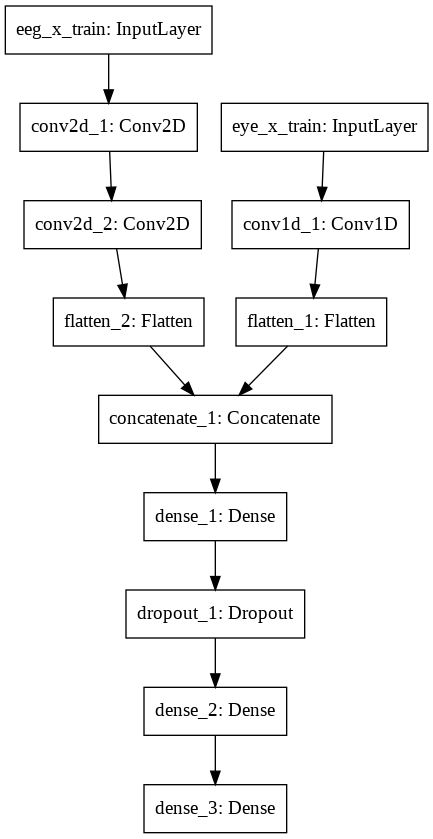

In [ ]:
backend.clear_session()

eye_inputs= Input(name='eye_x_train', shape=(31,64,))
eeg_inputs= Input(name='eeg_x_train', shape=(41,5,64,))

#eeg_inputs = Input(shape=(3,6,64)) #(eeg_x_train)
#eye_inputs= Input(shape=(31,64)) #(eye_x_train)


C1 = Conv1D(32, 3, activation='relu')(eye_inputs)
#M1= MaxPool1D(2)(C1)

#norm1 = BatchNormalization() (C1)
F1= Flatten()(C1)
#drop1=Dropout(0.4) (flat1)
#dense1=Dense(64, activation='relu')(drop)
#o1 = Dense(32, activation='softmax')(F1)
#x=Model(eye_inputs,o1)

C2 = Conv2D(32,(3,3), activation = 'relu')(eeg_inputs)
#M2= MaxPool2D((2,2))(C2)
C3 = Conv2D(32,(3,3), activation = 'relu')(C2)
#norm2=BatchNormalization()(C2)
F2=Flatten()(C3)
#drop2=Dropout(0.4) (flat2)
#o2=dense2=Dense(64, activation='relu')(F2)
#y=Model(eeg_inputs,o2)

# Concatentate
merge = Concatenate()([F1, F2])
#combined= Concatenate([x.output,y.output])

#flat=Flatten()(merge)
# Hidden connected layer and output
hidden = Dense(64, activation='relu')(merge)
drop = Dropout(0.3)(hidden)
hidden2 = Dense(64, activation='relu')(drop)

out = Dense(4, activation='softmax')(hidden2)

#model = Model([eye_inputs,eeg_inputs], out)

model=Model([eye_inputs,eeg_inputs],out)

from keras.optimizers import SGD, Adam
#opt = SGD(lr=0.0001)
opt= Adam(lr=0.0001)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# plot graph
plot_model(model)
#, show_shapes=True

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
eye_x_train (InputLayer)        (None, 31, 64)       0                                            
__________________________________________________________________________________________________
eeg_x_train (InputLayer)        (None, 5, 41, 64)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29, 32)       6176        eye_x_train[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 39, 32)    18464       eeg_x_train[0][0]                
____________________________________________________________________________________________

In [ ]:
eeg_x_train.shape

(648, 5, 41, 64)

In [ ]:
history = model.fit([eye_x_train,eeg_x_train], 
          y_train, 
          epochs = 50, 
          batch_size = 16,  
          validation_data=([eye_x_valid,eeg_x_valid], y_valid),
          verbose = 1 ,
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

Train on 648 samples, validate on 162 samples
Epoch 1/50
648/648 [==============================] - 1s 1ms/step - loss: 1.3127 - accuracy: 0.3627 - val_loss: 1.1907 - val_accuracy: 0.4074
Epoch 2/50
648/648 [==============================] - 1s 879us/step - loss: 1.1861 - accuracy: 0.4583 - val_loss: 1.0958 - val_accuracy: 0.4938
Epoch 3/50
648/648 [==============================] - 1s 866us/step - loss: 1.0943 - accuracy: 0.4907 - val_loss: 0.9654 - val_accuracy: 0.5309
Epoch 4/50
648/648 [==============================] - 1s 879us/step - loss: 1.0222 - accuracy: 0.5093 - val_loss: 0.9983 - val_accuracy: 0.4630
Epoch 5/50
648/648 [==============================] - 1s 922us/step - loss: 0.9545 - accuracy: 0.5509 - val_loss: 0.9155 - val_accuracy: 0.5988
Epoch 6/50
648/648 [==============================] - 1s 878us/step - loss: 0.8619 - accuracy: 0.6080 - val_loss: 0.7302 - val_accuracy: 0.6049
Epoch 7/50
648/648 [==============================] - 1s 910us/step - loss: 0.8834 - accurac

In [ ]:
# tools for plotting confusion matrices
from matplotlib import pyplot as plt

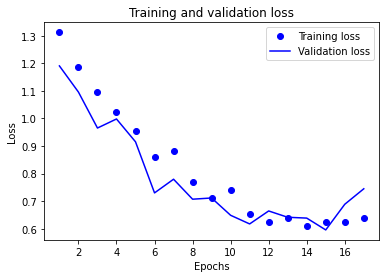

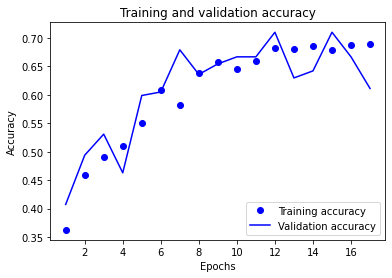

270/270 [==============================] - 0s 233us/step
test_acc: 0.7333333492279053


In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate([eye_x_test,eeg_x_test], y_test)
print('test_acc:', test_acc)